In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

Create 20000 FGK dwarfs using the age distribution from Berger et al 2020a, with planets drawn from loguniform period distribution from 2 to 300 days, following the following cases:<br>

1) no difference between old and young stars, with 3 planets per star <br>
2) 10% of systems still intact (5 or 6 planets; < 2 Gyr old); 90% of systems disrupted (1 or 2 planets; > 2 Gyr) <br>

Why these two cases? Kepler data shows 7% (here we round to 10%) of systems are intact. We're using 2 Gyr instead of 1 Gyr like Berger et al in order to maintain the ~10%/90% proportion of sample sizes. ME FROM THE FUTURE: This is a wrong assumption. Skip to end of Case 2. <br>

#### The goal is to find out how many of these systems have transiting planets.

### Case 1

In [3]:
berger_kepler = pd.read_csv('berger_kepler_stellar17.csv')
print(len(berger_kepler))
print(berger_kepler.head())

19969
    kepid           tm_designation  teff  teff_err1  teff_err2   logg  \
0  757280  2MASS J19242289+3633538  6543      162.0     -194.0  4.082   
1  892667  2MASS J19243045+3637186  6609      159.0     -227.0  4.105   
2  892678  2MASS J19243108+3638316  6137      167.0     -186.0  3.936   
3  892713  2MASS J19243353+3637220  6106      186.0     -186.0  3.854   
4  892828  2MASS J19243904+3637166  6691      188.0     -235.0  4.134   

   logg_err1  logg_err2  feh_x  feh_err1  ...  parallax  parallax_err  feh_y  \
0      0.258     -0.172  -0.24      0.25  ...    1.2137        0.0220    NaN   
1      0.246     -0.164  -0.26      0.25  ...    0.8512        0.0154    NaN   
2      0.428     -0.143  -0.26      0.30  ...    1.0236        0.0259    NaN   
3      0.496     -0.124  -0.24      0.30  ...    0.9602        0.0231    NaN   
4      0.209     -0.171  -0.26      0.25  ...    0.9660        0.0143    NaN   

   feh_err    RUWE  num_gaia_companions  Kmag_final_prov  evstate      log

/Users/chris/anaconda2/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (138) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


[ 409 1918 2978 3679 3709 2930 1248  638  469  431  369  348  290  211
  153   85   53   38    9    4]
[0.14   0.5575 0.975  1.3925 1.81   2.2275 2.645  3.0625 3.48   3.8975
 4.315  4.7325 5.15   5.5675 5.985  6.4025 6.82   7.2375 7.655  8.0725
 8.49  ]


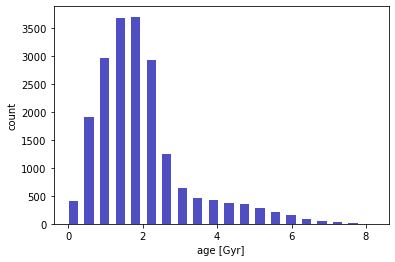

In [4]:
# age histogram for the 20000 FGK non-binary dwarfs from Berger et al 2020a with well-constrained ages
nbins = 20
age_hist, age_bin_edges = np.histogram(berger_kepler.iso_age, bins=nbins)
print(age_hist)
print(age_bin_edges)
plt.bar(age_bin_edges[:-1], age_hist, width = 0.25, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("age [Gyr]")
plt.show()

Time for kernel density estimator? https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html

/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


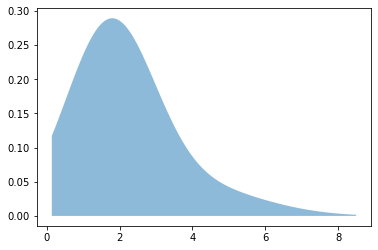

In [5]:
from sklearn.neighbors import KernelDensity

x = berger_kepler.iso_age
# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=1.0, kernel='gaussian') # what else might be better?
kde.fit(x[:, None])

x_d = np.linspace(np.min(x),np.max(x),1000)
# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d[:, None])

plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.show()

0.16134894568048957
0.13801577758850292
20000 [1.3853954  2.79795796 2.07078078 ... 1.89525526 1.71137137 1.84510511]


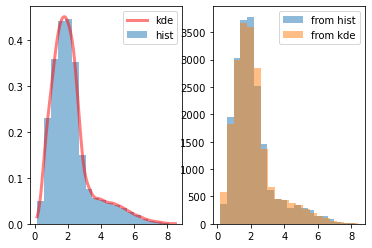

[1.3853954  2.79795796 2.07078078 ... 1.89525526 1.71137137 1.84510511]


In [8]:
# courtesy of https://stackoverflow.com/questions/17821458/random-number-from-histogram
from scipy.stats import gaussian_kde

def generate_rand_from_pdf(pdf, x_grid, n):
    cdf = np.cumsum(pdf) # create cdf
    cdf = cdf / cdf[-1] # normalize cdf
    values = np.random.rand(n) 
    value_bins = np.searchsorted(cdf, values) # return positions in cdf vector where random values should go
    random_from_cdf = x_grid[value_bins] # select x_d positions based on these random positions
    return random_from_cdf

def kde(x, x_grid, bandwidth):
    """Kernel Density Estimation with Scipy"""
    #kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=0)) # ddof=1 means std divisor is N-1 instead of N
    #kde = gaussian_kde(x, bw_method=np.power(len(x), -0.2)) # ddof=1 means std divisor is N-1 instead of N
    kde = gaussian_kde(x, bw_method=0.15) # constant bandwidth so imbalance in sample size doesn't drive distribution
    print(bandwidth/x.std(ddof=1)) # this is bw used in S/O
    print(np.power(len(x), -0.2)) # the bw if I use Scott's factor as the bw to multiply with covariance matrix
    return kde.evaluate(x_grid)

#kdepdf = kde(x, x_d, bandwidth=0.1) # generate KDE model
#random_from_kde = generate_rand_from_pdf(kdepdf, x_d) # generate random data from KDE distribution

nbins = 20
def run_kde(data, draws):
    hist, bins = np.histogram(data, bins=100)

    x_grid = np.linspace(min(data), max(data), 1000)
    kdepdf = kde(data, x_grid, bandwidth=0.2) # generate KDE model
    random_from_kde = generate_rand_from_pdf(kdepdf, x_grid, draws) # generate random data from KDE distribution
    print(len(random_from_kde), random_from_kde) # these are my star ages
    bin_midpoints = bins[:-1] + np.diff(bins) / 2 # get positions of bin midpoints
    random_from_cdf = generate_rand_from_pdf(hist, bin_midpoints, draws) # generate random data from the histogram

    plt.subplot(121)
    plt.hist(data, nbins, density=True, alpha=0.5, label='hist') # plot histogram of normalized data
    plt.plot(x_grid, kdepdf, color='r', alpha=0.5, lw=3, label='kde') # plot KDE over normalized histogram
    plt.legend()
    plt.subplot(122)
    plt.hist(random_from_cdf, nbins, alpha=0.5, label='from hist') # plot histogram of data drawn from OG histogram
    plt.hist(random_from_kde, nbins, alpha=0.5, label='from kde') # plot histogram of data drawn from KDE
    plt.legend()
    plt.show()
    return random_from_kde, random_from_cdf
    
stars_age1_kde, stars_age1_cdf = run_kde(berger_kepler.iso_age, 20000)
print(stars_age1_kde)

60000 [189.8365658   17.23509316  11.55102484 ... 100.20178156  15.85183571
   6.25400812]
[25620  7635  4482  3408  2639  2153  1759  1499  1423  1225  1150  1022
   979   851   793   729   714   719   595   605]
[  2.00001412  16.89711711  31.79422011  46.69132311  61.5884261
  76.4855291   91.38263209 106.27973509 121.17683809 136.07394108
 150.97104408 165.86814708 180.76525007 195.66235307 210.55945607
 225.45655906 240.35366206 255.25076505 270.14786805 285.04497105
 299.94207404]


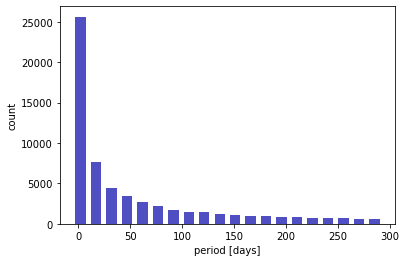

In [9]:
# host star follows age distribution of Berger et al 2020a
# 3 planets per star, with periods following loguniform distribution in [2, 300] days
from scipy.stats import loguniform

planets_per1 = loguniform.rvs(2, 300, size=60000)
print(len(planets_per1), planets_per1)

# histogram for 60000 planet periods
per_hist, per_bin_edges = np.histogram(planets_per1, bins=nbins)
print(per_hist)
print(per_bin_edges)
plt.bar(per_bin_edges[:-1], per_hist, width = 10, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("period [days]")
plt.show()

[2950 3025 2999 2943 3011 2997 3098 3004 3082 2993 3030 2926 2981 3072
 3057 2933 2972 3013 2947 2967]
[0.69315424 0.943676   1.19419775 1.44471951 1.69524126 1.94576302
 2.19628478 2.44680653 2.69732829 2.94785005 3.1983718  3.44889356
 3.69941532 3.94993707 4.20045883 4.45098059 4.70150234 4.9520241
 5.20254586 5.45306761 5.70358937]


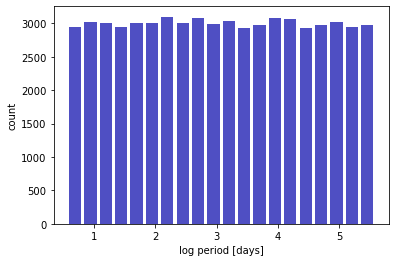

In [10]:
per_hist, per_bin_edges = np.histogram(np.log(planets_per1), bins=nbins)
print(per_hist)
print(per_bin_edges)
plt.bar(per_bin_edges[:-1], per_hist, width = 0.2, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("log period [days]")
plt.show()

### Case 2

1.1170311000339714
0.20889447103113198
2000 [0.86570571 0.99311311 0.72882883 ... 0.94834835 0.83557558 0.72366366]


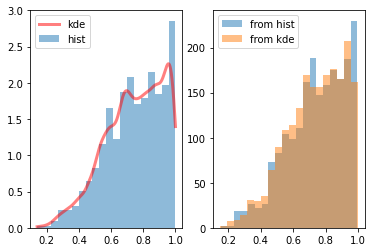

In [11]:
# 2000 systems with five or six planets and age <2 Gyr
# 18000 systems with one or two planets and age >2 Gyr
# should the age distribution be a truncated version of the KDE below and above 2 Gyr? yes
# going back and using a threshold of 1 Gyr like Berger et al 2020 b/c the proportion of young/old is more realistic
young = berger_kepler.loc[berger_kepler.iso_age <= 1.].iso_age
old = berger_kepler.loc[berger_kepler.iso_age > 1.].iso_age

stars_age2_young_kde, stars_age2_young_cdf = run_kde(young, 2000)

11000 [177.48062267   2.94338654  22.58955145 ...  60.97081183   5.82012567
 151.42933013]
[4658 1388  836  626  528  354  319  283  246  227  205  191  179  168
  163  130  128  129  115  127]
[  2.00008421  16.88038844  31.76069266  46.64099689  61.52130112
  76.40160535  91.28190958 106.16221381 121.04251803 135.92282226
 150.80312649 165.68343072 180.56373495 195.44403918 210.3243434
 225.20464763 240.08495186 254.96525609 269.84556032 284.72586454
 299.60616877]


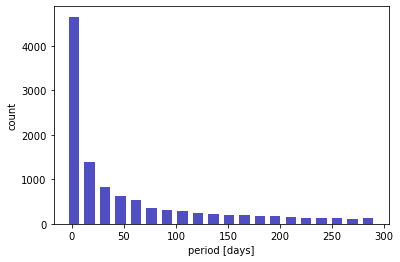

In [12]:
# generate five or six planets for each of the 2000 systems --> 11000 planets
planets_per2_young = loguniform.rvs(2, 300, size=11000)
print(len(planets_per2_young), planets_per2_young)

# histogram for 11000 planet periods
per_hist, per_bin_edges = np.histogram(planets_per2_young, bins=nbins)
print(per_hist)
print(per_bin_edges)
plt.bar(per_bin_edges[:-1], per_hist, width = 10, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("period [days]")
plt.show()

0.16776569556283707
0.14178034518473398
18000 [2.28287287 2.16307307 1.42181181 ... 2.08071071 2.1480981  2.0881982 ]


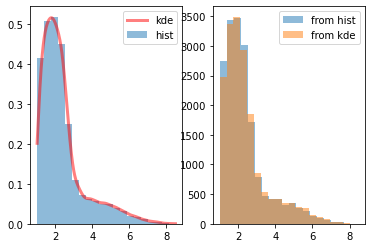

In [13]:
stars_age2_old_kde, stars_age2_old_cdf = run_kde(old, 18000)

27000 [147.30895513  22.72978269  94.8140186  ... 109.7964035    3.79301848
   5.85893307]
[11462  3458  2150  1486  1174   910   795   673   633   551   514   484
   415   384   381   323   352   274   280   301]
[  2.00035337  16.89787117  31.79538896  46.69290675  61.59042455
  76.48794234  91.38546014 106.28297793 121.18049573 136.07801352
 150.97553131 165.87304911 180.7705669  195.6680847  210.56560249
 225.46312028 240.36063808 255.25815587 270.15567367 285.05319146
 299.95070926]


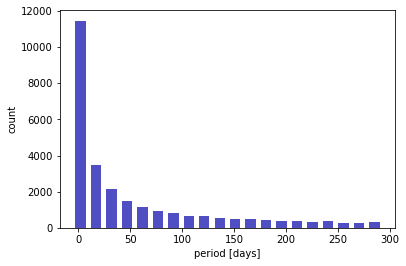

In [14]:
# generate one or two planets for each of the 18000 systems --> 27000 planets
planets_per2_young = loguniform.rvs(2, 300, size=27000)
print(len(planets_per2_young), planets_per2_young)

# histogram for 27000 planet periods
per_hist, per_bin_edges = np.histogram(planets_per2_young, bins=nbins)
print(per_hist)
print(per_bin_edges)
plt.bar(per_bin_edges[:-1], per_hist, width = 10, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("period [days]")
plt.show()

In [ ]:
"""# age histogram for the Case 2 2000 synthetic young and 18000 synthetic old stars drawn from Berger age distribution, 2 Gyr threshold
nbins = 20
age_hist, age_bin_edges = np.histogram(list(stars_age2_young)+list(stars_age2_old), bins=nbins)
print(age_hist)
print(age_bin_edges)
plt.bar(age_bin_edges[:-1], age_hist, width = 0.25, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("age [Gyr]")
plt.show()
"""

Why da peak so high?? As we can see below, the 1 Gyr threshold is actually closer to the 10% split than the 2 Gyr threshold. So let's fall back to that.

In [17]:
# check percentage split of 1 Gyr age threshold vs 2 Gyr
print(len(berger_kepler.loc[berger_kepler.iso_age <= 1.]))
print(len(berger_kepler.loc[berger_kepler.iso_age > 1.]))
print(2514/len(berger_kepler))

print(len(berger_kepler.loc[berger_kepler.iso_age <= 2.]))
print(len(berger_kepler.loc[berger_kepler.iso_age > 2.]))
print(10814/len(berger_kepler))

# now check what threshold yields a 10%/90% young/old split
youngest_ten_percent = berger_kepler.iso_age.sort_values().head(int(len(berger_kepler)*(0.1))) # sort by ages and get first 10%
print(len(youngest_ten_percent))
print(youngest_ten_percent.tail())
print(len(stars_age1_kde[:int(len(stars_age1_kde) * 0.1)]))
print(stars_age1_kde[:int(len(stars_age1_kde) * 0.1)])


2514
17455
0.12589513746306777
10814
9155
0.5415393860483749
1996
11450    0.91
2020     0.92
11791    0.92
16754    0.92
919      0.92
Name: iso_age, dtype: float64
2000
[1.3853954  2.79795796 2.07078078 ... 1.29345345 2.57228228 2.11257257]


We'll go ahead and use 1 Gyr for now; we'll know from the transit simulation work whether a compact multi rate of 12.6% is consistent with the observed Kepler sample. Tuning this to get it to reproduce Kepler observations will be one of the next few steps anyway.

[ 359 1540 2632 3822 3756 2980 1497  734  507  479  395  377  314  257
  145  104   41   40   16    5]
[0.14774775 0.56074224 0.97373674 1.38673123 1.79972573 2.21272022
 2.62571471 3.03870921 3.4517037  3.8646982  4.27769269 4.69068719
 5.10368168 5.51667618 5.92967067 6.34266517 6.75565966 7.16865415
 7.58164865 7.99464314 8.40763764]


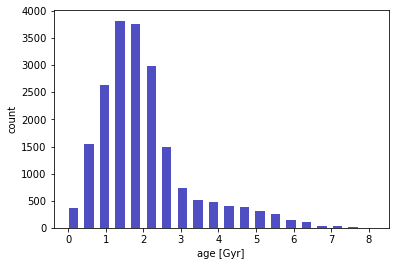

In [18]:
# age histogram for the Case 2 2000 synthetic young and 18000 synthetic old stars 
# drawn from two piecewise KDEs of the Berger age distribution
# 1 Gyr threshold
nbins = 20
age_hist, age_bin_edges = np.histogram(list(stars_age2_young_kde)+list(stars_age2_old_kde), bins=nbins)
print(age_hist)
print(age_bin_edges)
plt.bar(age_bin_edges[:-1], age_hist, width = 0.25, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("age [Gyr]")
plt.show()

0.16134894568048957
0.13801577758850292
5053
34947


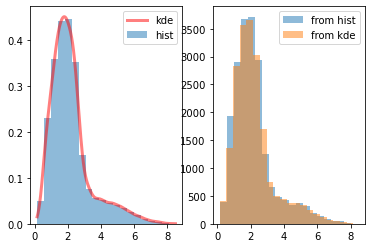

2000 18000


In [19]:
# maybe that was a bad idea to draw two separate piecewise KDEs
# instead, let's use the same KDE from Case 1 and just draw until we get 2000 young and 18000 old stars
def generate_rand_from_pdf_case2(pdf, x_grid, n_young, n_old):
    cdf = np.cumsum(pdf) # create cdf
    cdf = cdf / cdf[-1] # normalize cdf
    values = np.random.rand(2*(n_young+n_old))
    value_bins = np.searchsorted(cdf, values) # return positions in cdf vector where random values should go
    random_from_cdf = x_grid[value_bins] # select x_d positions based on these random positions
    # select 2000 young from Case 1 KDE draw
    case2_young = [i for i in random_from_cdf if i <= 1.]
    print(len(case2_young))
    case2_young = random.sample(case2_young, 2000)
    # else select old
    case2_old = [i for i in random_from_cdf if i > 1.]
    print(len(case2_old))
    case2_old = random.sample(case2_old, 18000)
    return case2_young, case2_old

def run_kde_case2(data, draws):
    hist, bins = np.histogram(data, bins=100)

    x_grid = np.linspace(min(data), max(data), 1000)
    kdepdf = kde(data, x_grid, bandwidth=0.2) # generate KDE model
    random_from_kde_young, random_from_kde_old = generate_rand_from_pdf_case2(kdepdf, x_grid, 2000, 18000) # generate random data from KDE distribution
    #print(len(random_from_kde), random_from_kde) # these are my star ages
    bin_midpoints = bins[:-1] + np.diff(bins) / 2 # get positions of bin midpoints
    random_from_cdf = generate_rand_from_pdf(hist, bin_midpoints, draws) # generate random data from the histogram

    plt.subplot(121)
    plt.hist(data, nbins, density=True, alpha=0.5, label='hist') # plot histogram of normalized data
    plt.plot(x_grid, kdepdf, color='r', alpha=0.5, lw=3, label='kde') # plot KDE over normalized histogram
    plt.legend()
    plt.subplot(122)
    plt.hist(random_from_cdf, nbins, alpha=0.5, label='from hist') # plot histogram of data drawn from OG histogram
    plt.hist(list(random_from_kde_young)+list(random_from_kde_old), nbins, alpha=0.5, label='from kde') # plot histogram of data drawn from KDE
    plt.legend()
    plt.show()
    return random_from_kde_young, random_from_kde_old

stars_age2_kde_young, stars_age2_kde_old = run_kde_case2(berger_kepler.iso_age, 20000)
print(len(stars_age2_kde_young), len(stars_age2_kde_old))

[ 412 1358 2827 3572 3651 3022 1704  751  494  438  368  366  331  252
  177  118   70   48   35    6]
[0.14       0.54161912 0.94323824 1.34485736 1.74647648 2.1480956
 2.54971471 2.95133383 3.35295295 3.75457207 4.15619119 4.55781031
 4.95942943 5.36104855 5.76266767 6.16428679 6.56590591 6.96752503
 7.36914414 7.77076326 8.17238238]


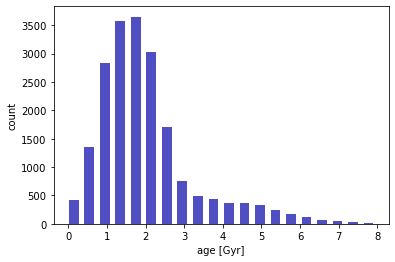

In [20]:
# age histogram for the Case 2 young and old stars, drawn from one continuous KDE fitted to Berger age distribution
# 1 Gyr threshold
nbins = 20
age_hist, age_bin_edges = np.histogram(list(stars_age2_kde_young)+list(stars_age2_kde_old), bins=nbins)
print(age_hist)
print(age_bin_edges)
plt.bar(age_bin_edges[:-1], age_hist, width = 0.25, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("age [Gyr]")
plt.show()

[ 580 1825 2993 3670 3590 2850 1370  679  448  436  380  345  268  197
  145  109   56   37   15    7]
[0.14835836 0.56126126 0.97416416 1.38706707 1.79996997 2.21287287
 2.62577578 3.03867868 3.45158158 3.86448448 4.27738739 4.69029029
 5.10319319 5.5160961  5.928999   6.3419019  6.7548048  7.16770771
 7.58061061 7.99351351 8.40641642]


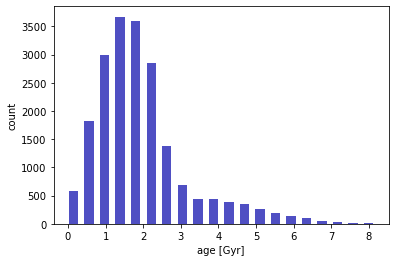

In [21]:
# age histogram for the Case 1 stars
# 1 Gyr threshold
nbins = 20
age_hist, age_bin_edges = np.histogram(list(stars_age1_kde), bins=nbins)
print(age_hist)
print(age_bin_edges)
plt.bar(age_bin_edges[:-1], age_hist, width = 0.25, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("age [Gyr]")
plt.show()

In [22]:
len([i for i in stars_age1_kde if i <= 1.])

2550

[ 409 1918 2978 3679 3709 2930 1248  638  469  431  369  348  290  211
  153   85   53   38    9    4]
[0.14   0.5575 0.975  1.3925 1.81   2.2275 2.645  3.0625 3.48   3.8975
 4.315  4.7325 5.15   5.5675 5.985  6.4025 6.82   7.2375 7.655  8.0725
 8.49  ]


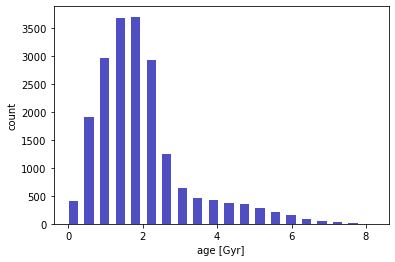

In [23]:
# age histogram for the 20000 FGK non-binary dwarfs from Berger et al 2020a with well-constrained ages
nbins = 20
age_hist, age_bin_edges = np.histogram(berger_kepler.iso_age, bins=nbins)
print(age_hist)
print(age_bin_edges)
plt.bar(age_bin_edges[:-1], age_hist, width = 0.25, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("age [Gyr]")
plt.show()

So there's three ways I can go about this. Do I 1) sample from 2 piecewise KDEs fit onto the <1 and >1 parts of the Berger age distribution; 2) sample generously from a single KDE on the Berger age distribution and draw however much I need from the <1 and >1 portions; or 3) just use the KDE from Case 1? Also, should I really be sampling 10%/90% if the true threshold is at 12.6%? If I do that, I'm undersampling for the already smaller young sample. And if I don't do that, then I might as well take option 3, right? <br> <br>

Let's just use the synthetic stars from Case 1 for now and fall back on different sampling proportions if the transit work doesn't look right, as Sarah said.

### Transits

0.38690748364419597
0.13801577758850292
20000 [2.39644645 2.19864064 1.82048248 ... 1.42487087 2.89677878 1.82048248]


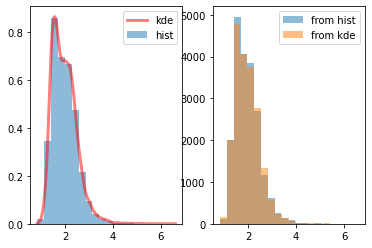

In [31]:
stars_radius_kde, stars_radius_cdf = run_kde(berger_kepler.iso_rad, 20000)

In [34]:
# we use stars_age1_kde and planets_per1
# for each system, draw the midplane from uniform distribution, then draw planets' line of transit from Gaussian
# Case 1

midplanes = []
midplanes_degrees = []
impact_parameters = []
impact_parameters_degrees = []
#planets_per_case1 = [] # maybe better to recreate it here b/c I can then generalize it for Case 2?
sigma = 0.1 # THIS IS A BIG HYPERPARAM
sigma_degrees = 60
for star in stars_age1_kde:
    # star
    mu = np.random.uniform(-np.pi/2,np.pi/2,1) # create midplane for star
    mu_degrees = np.random.uniform(-90,90,1) # more interpretable
    midplanes.append(mu)
    midplanes_degrees.append(mu_degrees)
    
    # planet
    impact_parameters.append(np.random.normal(mu, sigma, 3)) # create impact params for planets
    impact_parameters_degrees.append(np.random.normal(mu_degrees, sigma_degrees, 3)) # create impact params for planets in degrees
    
midplanes = np.concatenate(midplanes, axis=0) # turn list of lists of one into regular list

planets_per_case1 = [planets_per1[p:p+3] for p in range(0, len(planets_per1), 3)] # reorganize list into list of lists of three

transits_dict = {'star_ages': stars_age1_kde, 'planet_periods': planets_per_case1,
                'midplane': midplanes, 'midplane_degrees': midplanes_degrees,
                 'b': impact_parameters, 'b_degrees': impact_parameters_degrees, 'star_radius': stars_radius_kde}
transits_case1 = pd.DataFrame(transits_dict)
print(transits_case1.head())

   star_ages                                     planet_periods  midplane  \
0   1.385395  [189.836565797733, 17.235093157377314, 11.5510... -1.481668   
1   2.797958  [74.59060796566567, 2.8006115516298493, 54.487...  0.811416   
2   2.070781  [11.325652700792164, 75.20872413382943, 9.1053...  0.683880   
3   2.371682  [2.4812984404045433, 62.31417490483725, 19.536... -0.623075   
4   2.020631  [15.81584919716752, 44.565818768391054, 79.076...  1.363980   

       midplane_degrees                                                  b  \
0  [55.394591042510626]  [-1.3833388935532485, -1.4602203232916426, -1....   
1   [82.98155618168133]  [0.8880666309554475, 0.6669520659466392, 0.765...   
2  [-9.090392510191705]  [0.772569701438432, 0.7570365045645827, 0.6532...   
3   [67.47787606019781]  [-0.6101705176905111, -0.7289267669898181, -0....   
4  [-58.64069098348136]  [1.1822466635014466, 1.377824586325465, 1.3340...   

                                           b_degrees  star_radius  


In [33]:
# we use stars_age1_kde and planets_per1
# for each system, draw the midplane from uniform distribution, then draw planets' line of transit from Gaussian
# Case 2

midplanes = []
midplanes_degrees = []
impact_parameters = []
impact_parameters_degrees = []
planets_per_case1 = [] # maybe better to recreate it here b/c I can then generalize it for Case 2?
star_radius = []
sigma = 0.1 # THIS IS A BIG HYPERPARAM
sigma_degrees = 60
for star in stars_age1_kde:
    # star
    mu = np.random.uniform(-np.pi/2,np.pi/2,1) # create midplane for star
    mu_degrees = np.random.uniform(-90,90,1) # more interpretable
    midplanes.append(mu)
    midplanes_degrees.append(mu_degrees)
    
    # planet
    if star <= 1.:
        num_planets = random.choice([5, 6]) # young system has 5 or 6 planets
        planets_per_case1.append(loguniform.rvs(2, 300, size=num_planets)) # draw 5 or 6 planet periods from loguniform distribution
        impact_parameters.append(np.random.normal(mu, sigma, num_planets)) # create impact params for planets
        impact_parameters_degrees.append(np.random.normal(mu_degrees, sigma_degrees, num_planets)) # create impact params for planets in degrees
    elif star > 1.:
        num_planets = random.choice([1, 2]) # old system has 1 or 2 planets
        planets_per_case1.append(loguniform.rvs(2, 300, size=num_planets)) # draw 5 or 6 planet periods from loguniform distribution
        impact_parameters.append(np.random.normal(mu, sigma, num_planets)) # create impact params for planets
        impact_parameters_degrees.append(np.random.normal(mu_degrees, sigma_degrees, num_planets)) # create impact params for planets in degrees
        
midplanes = np.concatenate(midplanes, axis=0) # turn list of lists of one into regular list

#planets_per_case1 = [planets_per1[p:p+3] for p in range(0, len(planets_per1), 3)] # reorganize list into list of lists of three

transits_dict = {'star_ages': stars_age1_kde, 'planet_periods': planets_per_case1,
                'midplane': midplanes, 'midplane_degrees': midplanes_degrees,
                 'b': impact_parameters, 'b_degrees': impact_parameters_degrees, 'star_radius': stars_radius_kde}
transits_case2 = pd.DataFrame(transits_dict)
print(transits_case2.head())

   star_ages                            planet_periods  midplane  \
0   1.385395  [108.09530525225416, 15.107570342826465] -1.128114   
1   2.797958   [261.09613165529436, 4.018182100755729] -0.375517   
2   2.070781  [146.23925441024372, 21.840022931803883]  0.157944   
3   2.371682   [194.76498787165625, 11.08499741811434]  0.490884   
4   2.020631   [25.875674330368067, 5.850875034462642] -0.024484   

        midplane_degrees                                            b  \
0    [72.46081521281457]    [-1.042054202824761, -0.9364140436600488]   
1   [-36.25007689851321]   [-0.4427459254199086, -0.1479055448836485]   
2  [-33.322101347175064]   [0.06562385788439015, 0.33478082478696025]   
3   [-65.23822526267077]    [0.49794228607383983, 0.6037806017190694]   
4   [-36.54766853280221]  [-0.06501506346251851, 0.03216631063953071]   

                                   b_degrees  star_radius  
0    [4.343505520431691, 3.4593684460169527]     2.396446  
1    [5.585304591671701, 11.9004